In [2]:
import time
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms.classifiers import QSVC
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# Hybrid Quantum Multi-Accuracy for Taiwan Credit Loan Defaults

## Data Loading

In [24]:
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
dataset = (
    pd.read_excel(io=data_url, header=1)
    .drop(columns=["ID"])
    .rename(
        columns={"PAY_0": "PAY_1", "default payment next month": "default"}
    )
).sample(1000)

In [25]:
X_df = pd.get_dummies(dataset.drop(columns=["default"]))
X = X_df.drop(columns=["SEX", "EDUCATION", "MARRIAGE"]).to_numpy()
Y = dataset.loc[:, "default"].to_numpy()

In [82]:
mod = sm.Logit(Y, X)
res = mod.fit()
X_sig = X[:,res.pvalues <= 0.01]

Optimization terminated successfully.
         Current function value: 0.447910
         Iterations 9


## 2. Training Quantum Support Vector Classifier

We first define the feature map for transforming classical features into quantum states, and the circuit used as the Ansatz for the SVC.

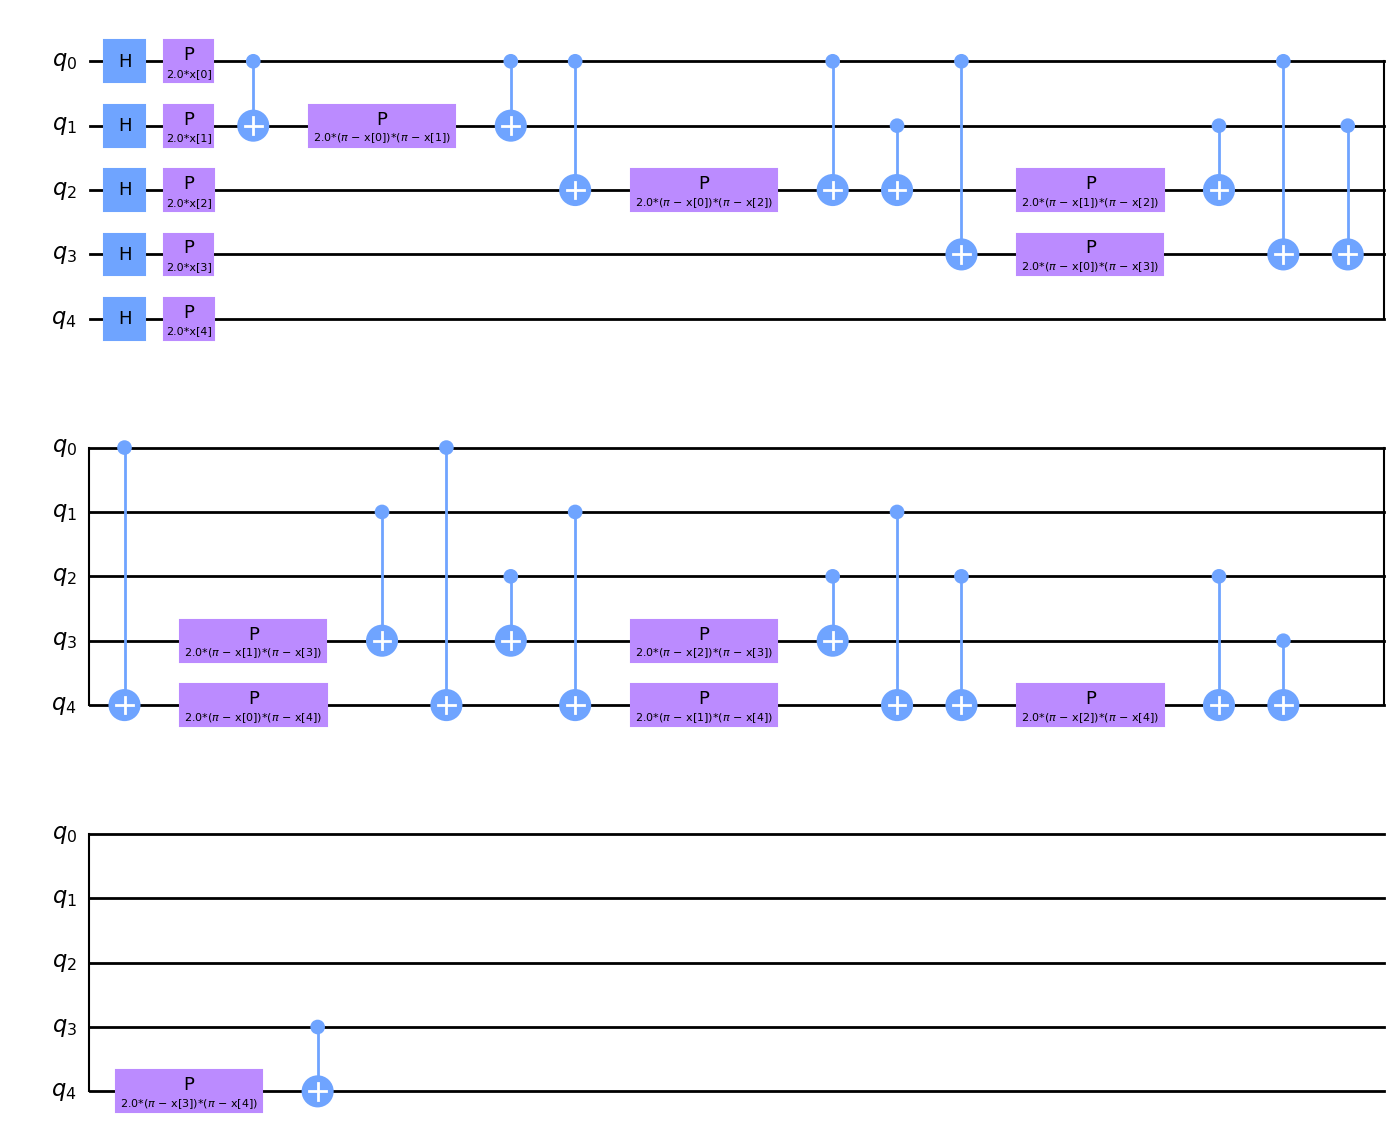

In [83]:
features = X_sig
labels = Y

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

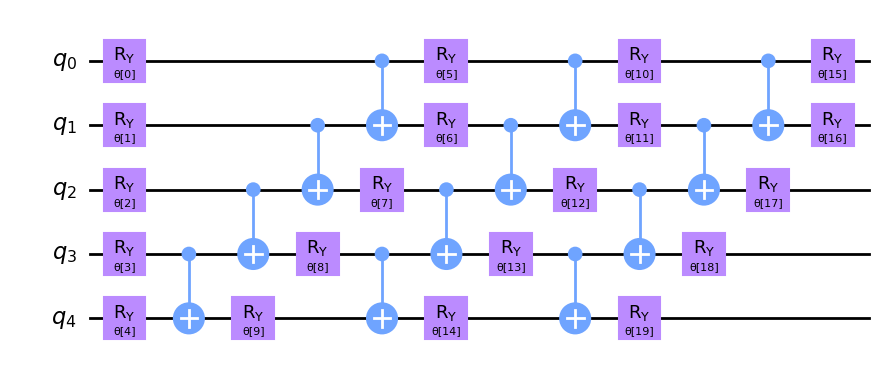

In [85]:
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

In [28]:
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

In [ ]:
qsvc = QSVC(quantum_kernel=kernel, probability=True)
qsvc.fit(features, labels)

In [ ]:
y_pred = qsvc.predict_proba(features)

<AxesSubplot: ylabel='Count'>

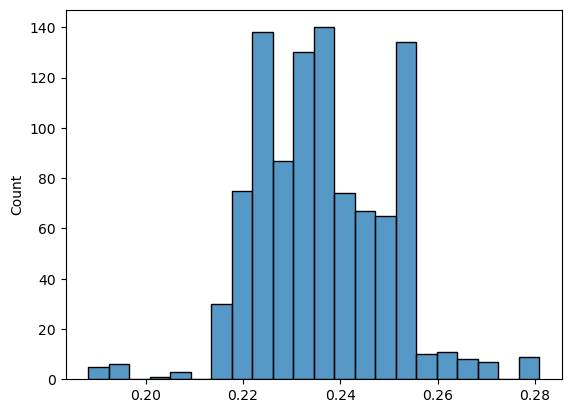

In [37]:
sns.histplot(y_pred[:,1])

## 3. Defining function class and computing multi-accuracy

We first define the boolean functions for each subpopulation (sex, education, and marital status, and compute the multi-accuracy quantity with respect to each group.)

In [75]:
sex_f = (X_df["SEX"] == 2).to_numpy()
education_f = (X_df["EDUCATION"] >= 3).to_numpy()
marriage_f = (X_df["MARRIAGE"] == 1).to_numpy()

print("Sex multiaccuracy:", np.mean(sex_f * np.abs(y_pred[:, 1] - labels)))
print("Education multiaccuracy:", np.mean(education_f * np.abs(y_pred[:, 1] - labels)))
print("Marriage multiaccuracy:", np.mean(marriage_f * np.abs(y_pred[:, 1] - labels)))

Sex multiaccuracy: 0.19526705537303293
Education multiaccuracy: 0.06374012635117247
Marriage multiaccuracy: 0.17151794329783457
